In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
train_path="/content/drive/MyDrive/plant_dataset/train"
validation_path="/content/drive/MyDrive/plant_dataset/validation"
test_path="/content/drive/MyDrive/plant_dataset/test"

In [ ]:
train_batches = tf.keras.utils.image_dataset_from_directory(train_path,
                                                            shuffle=True,
                                                            batch_size = 32,
                                                            image_size = (224,224))

validation_batches = tf.keras.utils.image_dataset_from_directory(validation_path,
                                                            shuffle=True,
                                                            batch_size = 32,
                                                            image_size = (224,224))

test_batches = tf.keras.utils.image_dataset_from_directory(test_path,
                                                            shuffle=False,
                                                            batch_size = 32,
                                                            image_size = (224,224))

Found 700 files belonging to 10 classes.
Found 200 files belonging to 10 classes.
Found 100 files belonging to 10 classes.


In [ ]:
IMG_SHAPE = (224,224,3)
base_model = tf.keras.applications.MobileNetV2(include_top=False,
                                               weights= 'imagenet',
                                               input_shape = IMG_SHAPE)

In [ ]:
base_model.trainable=False

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
preds = Dense(10, activation='softmax')(x)

model=Model(inputs, preds)

In [ ]:
epochs = 10
optimizer=Adam(learning_rate=0.0001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
history = model.fit(train_batches, validation_data=validation_batches, epochs=epochs)

Epoch 1/10
22/22 [==============================] - 49s 2s/step - loss: 2.0469 - accuracy: 0.3014 - val_loss: 1.4064 - val_accuracy: 0.6900
Epoch 2/10
22/22 [==============================] - 44s 2s/step - loss: 1.1451 - accuracy: 0.7429 - val_loss: 0.8167 - val_accuracy: 0.8800
Epoch 3/10
22/22 [==============================] - 42s 2s/step - loss: 0.6828 - accuracy: 0.8757 - val_loss: 0.5289 - val_accuracy: 0.9150
Epoch 4/10
22/22 [==============================] - 43s 2s/step - loss: 0.4272 - accuracy: 0.9429 - val_loss: 0.3799 - val_accuracy: 0.9450
Epoch 5/10
22/22 [==============================] - 42s 2s/step - loss: 0.2938 - accuracy: 0.9671 - val_loss: 0.2981 - val_accuracy: 0.9550
Epoch 6/10
22/22 [==============================] - 42s 2s/step - loss: 0.2277 - accuracy: 0.9714 - val_loss: 0.2513 - val_accuracy: 0.9600
Epoch 7/10
22/22 [==============================] - 42s 2s/step - loss: 0.1690 - accuracy: 0.9814 - val_loss: 0.2187 - val_accuracy: 0.9500
Epoch 8/10
22/22 [==

In [ ]:
model.evaluate(test_batches, verbose=2)

4/4 - 5s - loss: 0.1026 - accuracy: 0.9800 - 5s/epoch - 1s/step


[0.1025933101773262, 0.9800000190734863]

In [ ]:
test_labels = tf.concat([y for x, y in test_batches], axis=0)
preds = model.predict(test_batches, verbose=0)
cm = confusion_matrix(y_true=test_labels, y_pred=preds.argmax(axis=1))

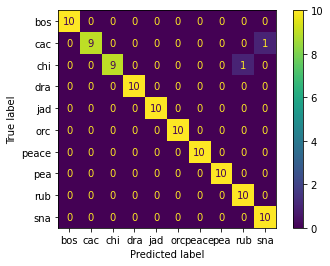

In [ ]:
cm_plot_labels = ['bos', 'cac', 'chi', 'dra', 'jad', 'orc', 'peace', 'pea', 'rub', 'sna']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cm_plot_labels)
disp.plot()

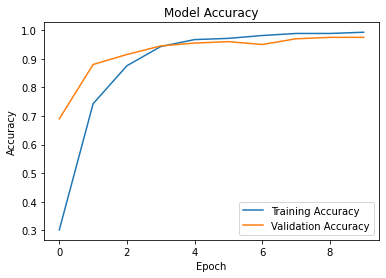

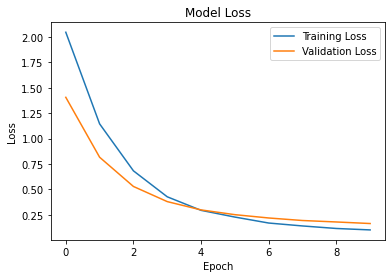

In [ ]:
# Plot model performance 
import matplotlib.pylab as plt
acc = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


plt.plot(acc, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Model Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Model Loss')
plt.legend(loc='upper right')
plt.show()

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open ("model2.tflite", 'wb') as f:
  f.write(tflite_model)